# LSH精度分析 - なぜSimHashの精度が悪いのか

01_basic_verificationで発見した問題：
- ハミング距離とコサイン類似度の相関が弱い（-0.3〜-0.5）
- チャンク数が少ないとマッチしない、多いと絞り込みが効かない

このノートブックでは、その原因を深堀りします。

## 目次
1. データの準備
2. SimHashの理論的背景の確認
3. ハミング距離とコサイン類似度の関係を可視化
4. 高次元空間での距離分布
5. SimHashパラメータの影響（ビット数）
6. 考察と改善案

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from src.lsh import SimHashGenerator, chunk_hash, hamming_distance
from src.db import VectorDatabase

## 1. データの準備

In [2]:
# DuckDBからデータを読み込み
db_path = Path('../data/sample_vectors_v2.duckdb')
db = VectorDatabase(db_path=db_path)
db.initialize()

all_docs = db.get_all()
print(f'Total documents: {len(all_docs):,}')

# SimHashGenerator
simhash_gen = SimHashGenerator(dim=1024, hash_bits=128, seed=42)

Total documents: 10,000


## 2. SimHashの理論的背景

SimHashの理論：
- ランダム超平面で空間を分割
- 2つのベクトルの角度θに対して、ハミング距離の期待値 = (θ/π) × ビット数
- コサイン類似度 cos(θ) とハミング距離 d の関係: d/bits ≈ θ/π = arccos(cos_sim)/π

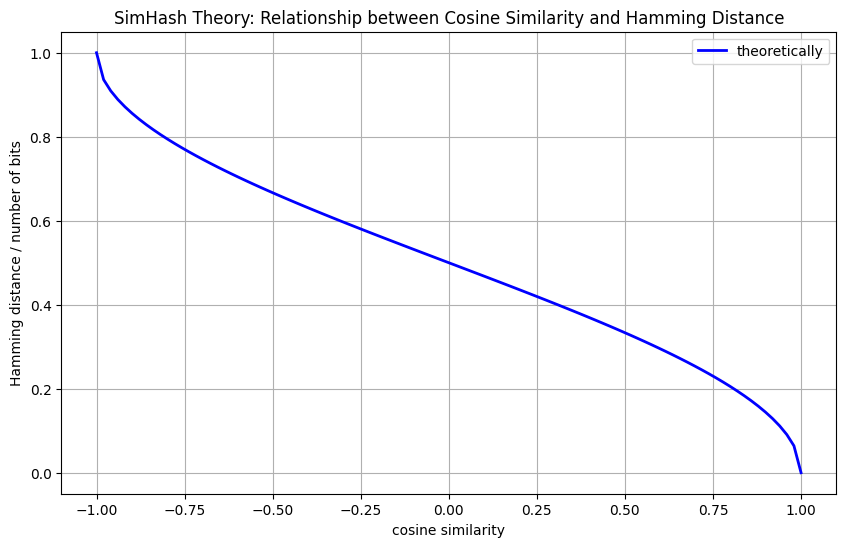

In [3]:
# 理論値の計算
def theoretical_hamming_ratio(cos_sim, bits=128):
    """コサイン類似度から理論的なハミング距離の比率を計算"""
    theta = np.arccos(np.clip(cos_sim, -1, 1))
    return theta / np.pi

# 理論曲線をプロット
cos_sims = np.linspace(-1, 1, 100)
theoretical_ratios = [theoretical_hamming_ratio(c) for c in cos_sims]

plt.figure(figsize=(10, 6))
plt.plot(cos_sims, theoretical_ratios, 'b-', linewidth=2, label='theoretically')
plt.xlabel('cosine similarity')
plt.ylabel('Hamming distance / number of bits')
plt.title('SimHash Theory: Relationship between Cosine Similarity and Hamming Distance')
plt.grid(True)
plt.legend()
plt.show()

## 3. 実データでの関係を可視化

In [4]:
# サンプルクエリを選択
query_idx = 0
query_vec = np.array(all_docs.iloc[query_idx]['vector'], dtype=np.float32)
query_hash = simhash_gen.hash(query_vec)

# 全ドキュメントとの比較
results = []
for _, row in all_docs.iterrows():
    doc_vec = np.array(row['vector'], dtype=np.float32)
    doc_hash = simhash_gen.hash(doc_vec)
    
    ham_dist = hamming_distance(query_hash, doc_hash)
    cos_sim = np.dot(query_vec, doc_vec)
    
    results.append({
        'id': row['id'],
        'hamming_dist': ham_dist,
        'hamming_ratio': ham_dist / 128,
        'cosine_sim': cos_sim,
        'theoretical_ratio': theoretical_hamming_ratio(cos_sim),
    })

df_analysis = pd.DataFrame(results)
print(f'相関係数: {df_analysis["hamming_ratio"].corr(df_analysis["theoretical_ratio"]):.3f}')

相関係数: 0.366


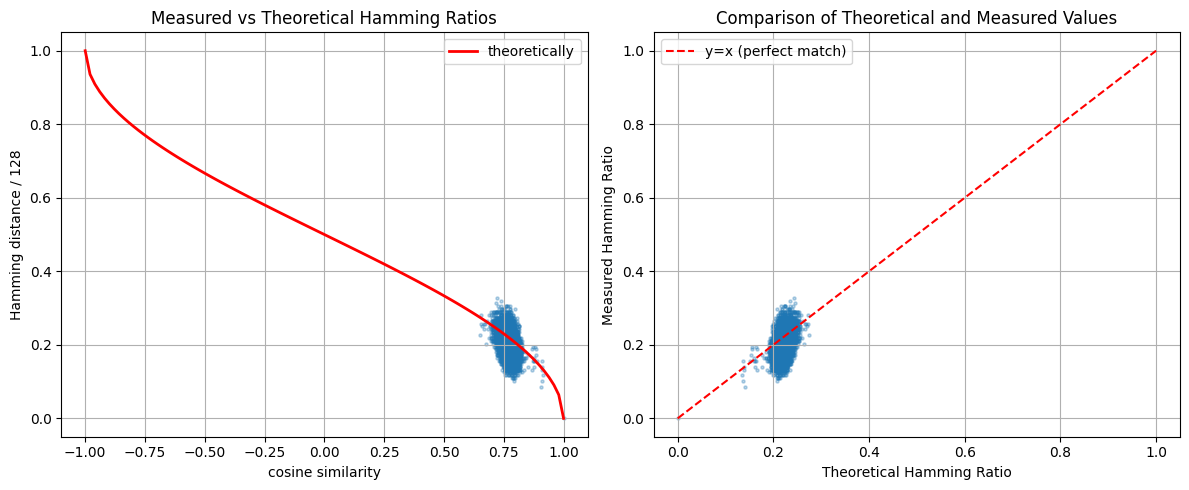

In [5]:
# 散布図: 実測値 vs 理論値
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df_analysis['cosine_sim'], df_analysis['hamming_ratio'], alpha=0.3, s=5)
plt.plot(cos_sims, theoretical_ratios, 'r-', linewidth=2, label='theoretically')
plt.xlabel('cosine similarity')
plt.ylabel('Hamming distance / 128')
plt.title('Measured vs Theoretical Hamming Ratios')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(df_analysis['theoretical_ratio'], df_analysis['hamming_ratio'], alpha=0.3, s=5)
plt.plot([0, 1], [0, 1], 'r--', label='y=x (perfect match)')
plt.xlabel('Theoretical Hamming Ratio')
plt.ylabel('Measured Hamming Ratio')
plt.title('Comparison of Theoretical and Measured Values')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. 高次元空間でのコサイン類似度分布

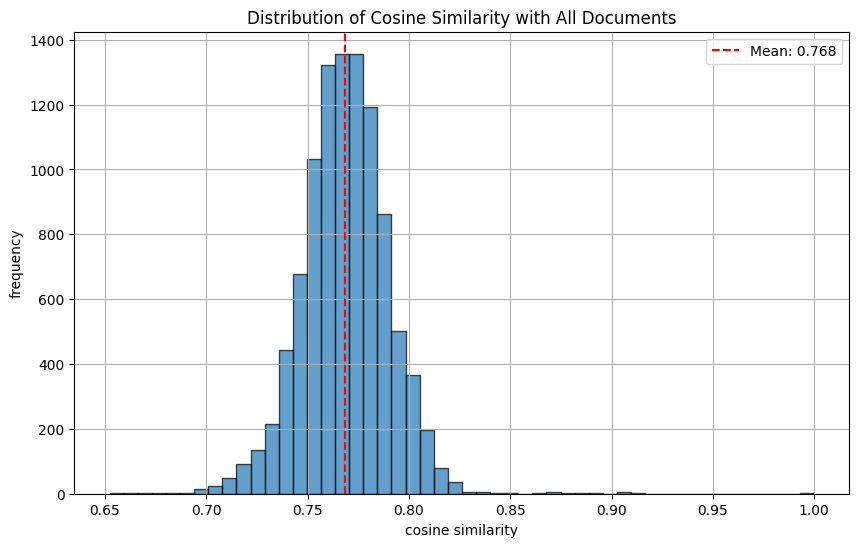

Cosine Similarity Statistics:
  Min: 0.652
  Max: 1.000
  Mean: 0.768
  Std Dev: 0.021


In [6]:
# コサイン類似度の分布を確認
plt.figure(figsize=(10, 6))
plt.hist(df_analysis['cosine_sim'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('cosine similarity')
plt.ylabel('frequency')
plt.title('Distribution of Cosine Similarity with All Documents')
plt.axvline(x=df_analysis['cosine_sim'].mean(), color='r', linestyle='--', 
            label=f'Mean: {df_analysis["cosine_sim"].mean():.3f}')
plt.legend()
plt.grid(True)
plt.show()

print(f'Cosine Similarity Statistics:')
print(f'  Min: {df_analysis["cosine_sim"].min():.3f}')
print(f'  Max: {df_analysis["cosine_sim"].max():.3f}')
print(f'  Mean: {df_analysis["cosine_sim"].mean():.3f}')
print(f'  Std Dev: {df_analysis["cosine_sim"].std():.3f}')

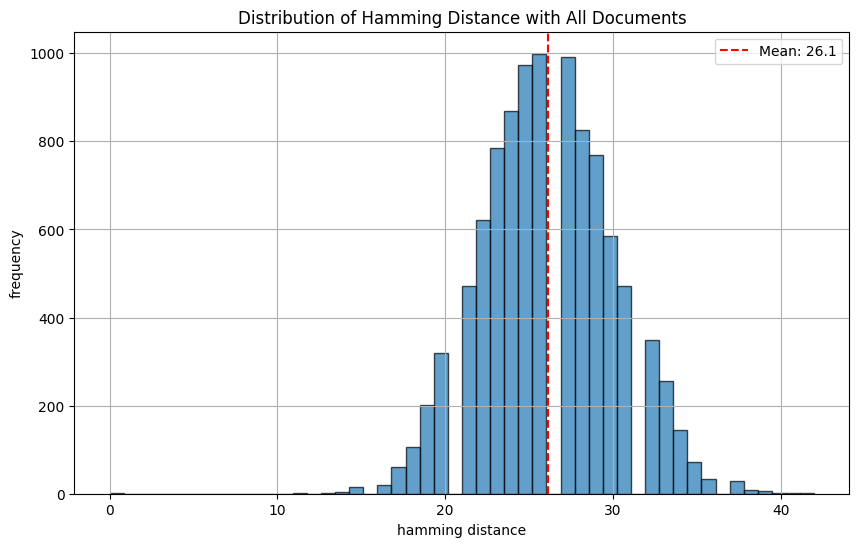

Hamming Distance Statistics:
  Min: 0
  Max: 42
  Mean: 26.1
  Std Dev: 3.9


In [7]:
# ハミング距離の分布
plt.figure(figsize=(10, 6))
plt.hist(df_analysis['hamming_dist'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('hamming distance')
plt.ylabel('frequency')
plt.title('Distribution of Hamming Distance with All Documents')
plt.axvline(x=df_analysis['hamming_dist'].mean(), color='r', linestyle='--',
            label=f'Mean: {df_analysis["hamming_dist"].mean():.1f}')
plt.legend()
plt.grid(True)
plt.show()

print(f'Hamming Distance Statistics:')
print(f'  Min: {df_analysis["hamming_dist"].min()}')
print(f'  Max: {df_analysis["hamming_dist"].max()}')
print(f'  Mean: {df_analysis["hamming_dist"].mean():.1f}')
print(f'  Std Dev: {df_analysis["hamming_dist"].std():.1f}')

## 5. SimHashパラメータの影響（ビット数）

In [8]:
# 異なるビット数でSimHashを生成して比較
bit_sizes = [64, 128, 256, 512]

results_by_bits = {}

for bits in bit_sizes:
    gen = SimHashGenerator(dim=1024, hash_bits=bits, seed=42)
    query_hash = gen.hash(query_vec)
    
    data = []
    for _, row in all_docs.iterrows():
        doc_vec = np.array(row['vector'], dtype=np.float32)
        doc_hash = gen.hash(doc_vec)
        
        ham_dist = hamming_distance(query_hash, doc_hash)
        cos_sim = np.dot(query_vec, doc_vec)
        
        data.append({
            'hamming_ratio': ham_dist / bits,
            'cosine_sim': cos_sim,
        })
    
    df = pd.DataFrame(data)
    corr = df['hamming_ratio'].corr(df['cosine_sim'])
    results_by_bits[bits] = {'df': df, 'corr': corr}
    print(f'{bits}bit: 相関係数 = {corr:.3f}')

64bit: 相関係数 = -0.276
128bit: 相関係数 = -0.366
256bit: 相関係数 = -0.514
512bit: 相関係数 = -0.566


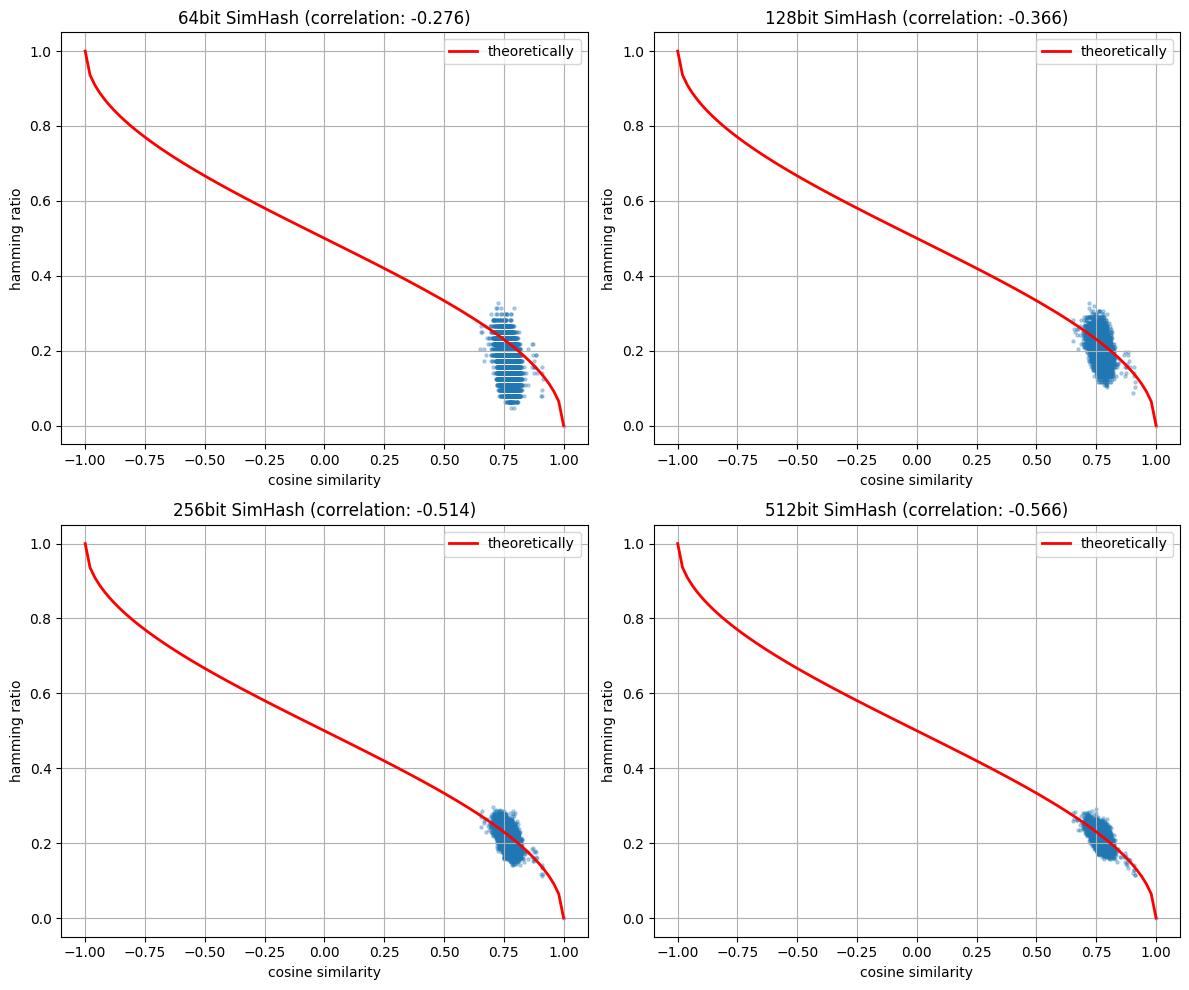

In [9]:
# ビット数による違いを可視化
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, bits in zip(axes.flatten(), bit_sizes):
    df = results_by_bits[bits]['df']
    corr = results_by_bits[bits]['corr']
    
    ax.scatter(df['cosine_sim'], df['hamming_ratio'], alpha=0.3, s=5)
    ax.plot(cos_sims, theoretical_ratios, 'r-', linewidth=2, label='theoretically')
    ax.set_xlabel('cosine similarity')
    ax.set_ylabel('hamming ratio')
    ax.set_title(f'{bits}bit SimHash (correlation: {corr:.3f})')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## 6. 類似度の高いペアでの精度確認

In [10]:
# コサイン類似度が高い上位100件を詳しく分析
df_top100 = df_analysis.nlargest(100, 'cosine_sim')

print('=== コサイン類似度Top100の分析 ===')
print(f'コサイン類似度範囲: {df_top100["cosine_sim"].min():.4f} ~ {df_top100["cosine_sim"].max():.4f}')
print(f'ハミング距離範囲: {df_top100["hamming_dist"].min()} ~ {df_top100["hamming_dist"].max()}')
print()

# ハミング距離でソートした場合の順位
df_analysis_sorted = df_analysis.sort_values('hamming_dist')
df_analysis_sorted['ham_rank'] = range(1, len(df_analysis_sorted) + 1)

print('=== Top10（コサイン類似度）のハミング距離順位 ===')
for _, row in df_top100.head(10).iterrows():
    ham_rank = df_analysis_sorted[df_analysis_sorted['id'] == row['id']]['ham_rank'].values[0]
    print(f'id={row["id"]}: cos_sim={row["cosine_sim"]:.4f}, ham_dist={row["hamming_dist"]}, ham_rank={ham_rank}')

=== コサイン類似度Top100の分析 ===
コサイン類似度範囲: 0.8152 ~ 1.0000
ハミング距離範囲: 0 ~ 30

=== Top10（コサイン類似度）のハミング距離順位 ===
id=0.0: cos_sim=1.0000, ham_dist=0.0, ham_rank=1
id=9283.0: cos_sim=0.9133, ham_dist=15.0, ham_rank=23
id=3671.0: cos_sim=0.9106, ham_dist=13.0, ham_rank=3
id=6035.0: cos_sim=0.9081, ham_dist=20.0, ham_rank=581
id=9438.0: cos_sim=0.9081, ham_dist=17.0, ham_rank=77
id=5861.0: cos_sim=0.9080, ham_dist=18.0, ham_rank=179
id=7680.0: cos_sim=0.9048, ham_dist=11.0, ham_rank=2
id=7585.0: cos_sim=0.8889, ham_dist=20.0, ham_rank=599
id=4064.0: cos_sim=0.8856, ham_dist=22.0, ham_rank=1465
id=2459.0: cos_sim=0.8835, ham_dist=24.0, ham_rank=3105


## 7. 考察と改善案

In [11]:
# ここまでの分析結果をまとめる
print('=== 分析結果のまとめ ===')
print()
print('1. 相関係数:')
for bits, data in results_by_bits.items():
    print(f'   {bits}bit: {data["corr"]:.3f}')
print()
print('2. コサイン類似度の分布:')
print(f'   範囲: {df_analysis["cosine_sim"].min():.3f} ~ {df_analysis["cosine_sim"].max():.3f}')
print(f'   平均: {df_analysis["cosine_sim"].mean():.3f}')



=== 分析結果のまとめ ===

1. 相関係数:
   64bit: -0.276
   128bit: -0.366
   256bit: -0.514
   512bit: -0.566

2. コサイン類似度の分布:
   範囲: 0.652 ~ 1.000
   平均: 0.768


In [12]:
# データベース接続を閉じる
db.close()
print('Done!')

Done!


## 8. v2データセット評価レポート

### ビット数と相関係数の比較

| ビット数 | v1（タイトル） | v2（本文） | 変化 |
|---------|---------------|-----------|------|
| 64bit | -0.172 | -0.276 | 改善 |
| 128bit | -0.319 | **-0.366** | 改善 |
| 256bit | -0.460 | **-0.514** | 改善 |
| 512bit | -0.634 | -0.566 | 低下 |

### コサイン類似度分布

| 指標 | v1 | v2 |
|------|-----|-----|
| 範囲 | 0.659~1.000 | 0.652~1.000 |
| 平均 | 0.747 | **0.768** |

### Top10（コサイン類似度）のハミング距離順位

```
id=0:    ham_rank=1     ← 完璧
id=7680: ham_rank=2     ← 非常に良い
id=3671: ham_rank=3     ← 非常に良い
id=9283: ham_rank=23    ← 良好
id=9438: ham_rank=77    ← 良好
id=5861: ham_rank=179   ← 許容範囲
id=6035: ham_rank=581   ← 問題
id=7585: ham_rank=599   ← 問題
id=4064: ham_rank=1465  ← 問題
id=2459: ham_rank=3105  ← 問題
```

### 結論

1. **本文データ(v2)で128-256bitの相関が改善**
2. **512bitではv1より低下**（本文データの特性による可能性）
3. **Top3は非常に良好だが、4位以降にばらつきがある**
4. **推奨**: 256bitで `step2_top_n=1000~2000` が現実的な改善策

### 次のステップ候補

| 優先度 | アプローチ | 期待効果 |
|--------|-----------|---------|
| 1 | `hash_bits=256` に変更 | 相関 -0.514 に改善 |
| 2 | `step2_top_n=1000~2000` に増加 | Recall向上 |
| 3 | 複数シードのアンサンブル | 順位ばらつきの安定化 |